## MSDS 7333 Project 1 -- Predicting Location via Indoor Positioning Systems

#### Stephen Hayden, Joe Schueder, Nicole Witten, Kevin Mendonsa



### Introduction

The Iowa Liquor  Sales dataset is an API from Google’s Bigquery which contains the wholesale purchases by retail stores in the Iowa area. The dataset includes the spirit purchase details by product, date of purchase, and location the item was purchased from an Iowa Class “E” liquor license holder (retail stores). The time frame of this data starts from January 1, 2012 through December 31, 2019. As part of the study commissioned by the Iowa Department of Commerce, all alcoholic sales within the state were logged into the Department system, and in turn, published as open data by the State of Iowa. The dataset contains detail on the name, product, quantity and location of the individual container or package sale between the wholesaler (vendor) and the retailer.

In [0]:
import pandas as pd

url_dataset = 'https://raw.githubusercontent.com/jjschueder/7331DataMiningNotebooks/master/Live%20Assignments/df1hotmerge2.csv'
data = pd.read_csv(url_dataset, nrows = 40000)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 68 columns):
Unnamed: 0                  40000 non-null int64
pack                        40000 non-null int64
bottle_volume_ml            40000 non-null int64
state_bottle_cost           40000 non-null float64
state_bottle_retail         40000 non-null float64
bottles_sold                40000 non-null int64
sale_dollars                40000 non-null float64
volume_sold_liters          40000 non-null float64
volume_sold_gallons         40000 non-null float64
counter                     40000 non-null int64
liquor_category             40000 non-null object
store_parent                40000 non-null object
month                       40000 non-null object
year                        40000 non-null int64
monthyear                   40000 non-null object
liquor_category_AMARETTO    40000 non-null int64
liquor_category_BRANDY      40000 non-null int64
liquor_category_GIN         40000 non-null i

Here you can see that we have 40,000 non null objects one-hot encoded to include month, year, store name and alcohol type. For our previous classification analysis, we dropped the liquor category and all the liquor types and just used the binary classification for Whiskey and Non-Whiskey. With 1 representing whether the liquor type was whiskey and 0 representing a non whiskey. 

In [0]:
# Import all necessary libraries we will be using in our dataset

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import math
import re
import sklearn
import statistics
import random

from sklearn.feature_selection import SelectKBest, chi2, SelectPercentile, RFE, SelectFromModel

from sklearn.preprocessing import StandardScaler, Binarizer

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC, LinearSVC

from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, auc, roc_curve
from IPython.display import display, HTML

from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, TimeSeriesSplit, StratifiedShuffleSplit

from sklearn.naive_bayes import MultinomialNB

from sklearn.ensemble import GradientBoostingClassifier,GradientBoostingRegressor,AdaBoostClassifier,RandomForestClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

%matplotlib inline

matplotlib.style.use('ggplot')

import warnings
warnings.filterwarnings('ignore')
print(data.shape)
data.head()


(40000, 68)


,Unnamed: 0,pack,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons,counter,liquor_category,store_parent,month,year,monthyear,liquor_category_AMARETTO,liquor_category_BRANDY,liquor_category_GIN,liquor_category_LIQUEUR,liquor_category_Other,liquor_category_RUM,liquor_category_SCHNAPPS,liquor_category_TEQUILA,liquor_category_VODKA,liquor_category_WHISKY,store_parent_CVS,store_parent_Caseys,store_parent_Hy-Vee,store_parent_Kum&Go,store_parent_Other,store_parent_QuikTrip,store_parent_SamsClub,store_parent_SmokingJoes,store_parent_Target,store_parent_Wal-Mart,store_parent_Walgreens,month_Apr,month_Aug,month_Dec,month_Feb,month_Jan,month_Jul,month_Jun,month_Mar,month_May,month_Nov,month_Oct,month_Sep,year_2019,monthyear_Apr-2019,monthyear_Aug-2019,monthyear_Dec-2019,monthyear_Feb-2019,monthyear_Jan-2019,monthyear_Jul-2019,monthyear_Jun-2019,monthyear_Mar-2019,monthyear_May-2019,monthyear_Nov-2019,monthyear_Oct-2019,monthyear_Sep-2019,sale_dollars_trans,cost_per_liter,cost_per_liter_trans,state_bottle_cost_trans,bottles_sold_trans,volume_sold_liters_trans,grossmargin
0,0,20,375,3.85,5.78,20,115.60,7.50,1.98,1,Other,Other,Nov,2019,Nov-19,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,4.750136,15.413333,2.735233,1.348073,2.995732,2.014903,0.333910
1,1,8,50,8.75,13.13,1,13.13,0.05,0.01,1,Other,Other,Nov,2019,Nov-19,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,2.574900,262.600000,5.570632,2.169054,0.000000,-2.995732,0.333587
2,2,12,1000,16.50,24.75,6,148.50,6.00,1.58,1,GIN,Hy-Vee,May,2019,May-19,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,5.000585,24.750000,3.208825,2.803360,1.791759,1.791759,0.333333
3,3,6,750,21.17,31.76,24,762.24,18.00,4.75,1,WHISKY,Hy-Vee,Nov,2019,Nov-19,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,6.636261,42.346667,3.745890,3.052585,3.178054,2.890372,0.333438
4,4,6,1750,9.31,13.97,12,167.64,21.00,5.54,1,Other,Hy-Vee,Nov,2019,Nov-19,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,5.121819,7.982857,2.077296,2.231089,2.484907,3.044522,0.333572


**Our data Preparation includes the folloiwng layout**

*   Since we are predicting our liquor category type (opening to the entire list of categories and not just one), we can assign them a numerical value.
* Create new variables using aggredate data on profit, total cost and revenue
*   Since we transformed a number of continuous variables, we can drop them so that we are working directly on our normalized data




## Modeling and Evaluation 1

Within this notebook, we have built multiple models to evaluate two classification problems.  The first, is a multi-classification problem in which our goal is to correctly classify the alcohol category based on sales data.  The second, is a binary classification to determine whether the alcohol sold is from a Hy-vee store vs a Non-Hy-vee store.  A detailed description of the metrics we will use to evaluate the models are noted below.

An ROC curve, also known as a Reciever Operation Characteristic Curve is a plot that calculates and can be used to compare the classifiers we will use in our modeling along with the true positive rate (TPR) and false positive rate (FPR) they convey. From a topline level, you can use the Area Under the Curve (AUC) to help detirmine which can better pair an observation with the correct liquor cateogry. An AUC score of 1.0 denotes a perfect classifier and an area of 0.5 represents a model is no better than a random guess.

In addition to the ROC-AUC value we will use to evaluate classifiers, we will be using other evaluators as well. 

**Accuracy** - Accuracy is the total number of correct predictions over the total number of predictions made. Accuracy will be plotted in our AUC curve and, while not perfect, is a good singlular measure to evaluate a model. Just be careful that we aren't overclassifying unbalalnced variables. 

Accuracy = (TP + TN)/(TP + FP + FN + TN)

**Precision** - Precision is the Proportions of true positives over the total number of positive outcomes whether accurately predicted or inaccurately predicted. Precision is useful to us because it will help us better understand which model is accurately picking correct classes and not resting on selecting incorrect classes. 

Precision = (TP) / (TP + FP)

**Recall** - Also known as sensitivity, recall is the proportion of positive outcomes that were correctly classified by our model. Essentially it tells us how many values we incorrectly predicted while the precision can tell us more about what we correctly classified. Recall is good as a pair with precision, as it will help us tell if our model is overfit or selecting a single class and not training itself. 

Recall/Sensitivity = (TP) / (TP + FN)

**F1 Score** - Another measure of accuracy that accounts for the true negatives and false positives. 

F1 score = 2(True Positive Rate * True Negatives)/(True Positives + True Negatives)

The aim of our modeling is to focus on maximizing our precision, recall, and accuracy scores in our models



In [0]:
#Source: https://github.com/jakemdrew/EducationDataNC/blob/master/2017/Models/2017ComparingSegregatedMiddleSchoolCampuses.ipynb
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold
cv = StratifiedKFold(n_splits=10)


def EvaluateClassifierEstimator(classifierEstimator, X, Y2, cv):



#Perform cross validation 
    scores = cross_validate(classifierEstimator, X, Y2,
                            scoring=['accuracy', 'precision','recall'], 
                            cv=cv, return_train_score=True, 
                            )

    Accavg = scores['test_accuracy'].mean()
    Preavg = scores['test_precision'].mean()
    Rreavg = scores['test_recall'].mean()

    print_str = "The average accuracy for all cv folds is: \t\t\t {Accavg:.5}"
    print_str2 = "The average precision for all cv folds is: \t\t\t {Preavg:.5}"
    print_str3 = "The average Recall for all cv folds is: \t\t\t {Rreavg:.5}"

    print(print_str.format(Accavg=Accavg))
    print(print_str2.format(Preavg=Preavg))
    print(print_str3.format(Rreavg=Rreavg))
    print('*********************************************************')

    print('Cross Validation Fold Mean Error Scores')
    scoresResults = pd.DataFrame()
    scoresResults['Accuracy'] = scores['test_accuracy']
    scoresResults['Precision'] = scores['test_precision']
    scoresResults['Recall'] = scores['test_recall']
    print(scoresResults)
    return scoresResults

def EvaluateClassifierEstimator2(classifierEstimator, X, Y2, cv):
    
  #Perform cross validation 
  from sklearn.model_selection import cross_val_predict
  predictions = cross_val_predict(classifierEstimator, 
                                  X, Y2, cv=cv)
    
#model evaluation 
  from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

#pass true test set values and predictions to classification_report
  classReport = classification_report(Y2,predictions)
  confMat = confusion_matrix(Y2,predictions)
  acc = accuracy_score(Y2,predictions)
    
  print(classReport)
  print(confMat)
  print(acc)
    
def EvaluateClassifierEstimator3(classifierEstimator, X, Y2, cv):
  from sklearn import metrics as mt
  for fold, (train_index, test_index) in enumerate(cv.split(X,Y2)):
     X_train = X[train_index]    
     y_train = Y2[train_index]  # Based on your code, you might need a ravel call here, but I would look into how you're generating your y
     X_test = X[test_index]
     y_test = Y2[test_index]  # See comment on ravel and  y_train
     sm = SMOTE(random_state=101)
     X_train_oversampled, y_train_oversampled = sm.fit_sample(X_train, y_train)
     classifierEstimator.fit(X_train, y_train) 
     y_pred = classifierEstimator.predict(X_test)
     acc = mt.accuracy_score(y_test,y_pred)
     conf = mt.confusion_matrix(y_test,y_pred)
     print("====Iteration",fold," ====")
     print("accuracy", acc )
     print("confusion matrix\n",conf)


## Modeling and Evaluation 2
Choose the method you will use for dividing your data into training and testing splits (i.e., are you using Stratified 10-fold cross validation? Why?). Explain why your chosen method is appropriate or use more than one method as appropriate. For example, if you are using time series data then you should be using continuous training and testing sets across time.

For our first classification problem, we identified an unbalanced distribution of alcohol categories within our dataset.  For example, Vodka is 38% of sales while Rum and Whiskey is 24% and 10% respectively.  To address this concern, we used a synthetic minority oversampling technique (SMOTE).  The SMOTE technique accounts for the minority classes withn the data by creating new synthetic instances similar to these minorities.  In other words, once SMOTE is used on the data we should have a balanced distribution between the different alcohol categories. 

Futhermore, to split our test & training data, we used a stratified k-fold cross validation method.  The number of splits used was 10, and our ratio of train vs test size was 80% to 20%.

The analysis and work performed regarding the SMOTE and CV method for Classification 1 is noted below. 

NOTE:  Details regarding the training and test splits for the second classification problem can be found within the Classification 2 (Store Data) section.

So we can begin to set a baseline for our accuracy score, let's do a quick look at the value counts and it's percent distribution of our liquor categories, the ones we are looking to classify. 

In [0]:
#class percentage split
dfgrp = data.groupby(['id_label','liquor_category'])
data_final['id_label'].value_counts()
dfgrp['counter'].count() / len(data_final) *100

id_label  liquor_category
1         Other               5.9650
10        BRANDY              0.0075
2         GIN                 4.2900
3         WHISKY             22.6125
4         TEQUILA             7.1325
5         LIQUEUR            13.4000
6         VODKA              32.7700
7         RUM                13.7875
8         SCHNAPPS            0.0050
9         AMARETTO            0.0300
Name: counter, dtype: float64

In [0]:
data_final['id_label'].value_counts()
dfgrp['counter'].count()

id_label  liquor_category
1         Other               2386
10        BRANDY                 3
2         GIN                 1716
3         WHISKY              9045
4         TEQUILA             2853
5         LIQUEUR             5360
6         VODKA              13108
7         RUM                 5515
8         SCHNAPPS               2
9         AMARETTO              12
Name: counter, dtype: int64

In [0]:
data_final = data_final[data_final['id_label'] < "8"]
data_final = data_final[data_final['id_label'] != "10"]
data_final['id_label'].value_counts()

6    13108
3     9045
7     5515
5     5360
4     2853
1     2386
2     1716
Name: id_label, dtype: int64

So that our model is able to run correctly without having to create a large amount of additional variables, we decided to drop the Amaretto, Schnapps and Brandy values since collectively, those represent 17 observations. 

In [0]:
data_final.shape

(39983, 12)

Looking at the distribution of liquors in our data_final dataset, we can see that vodka takes up 32% of the liquor sales in our set, followed by Rum at 13%, Liquer at 13%, Whisky at 22% and so on. When we run our classifier, we will need to be careful to account for the unbalanced nature of our classifiers to help ensure we aren't overclassifying the majority labels. 

For our data training, we will need to employ synthetic minority oversampling technique (SMOTE), which is designed to subset our data from the minority classes as an example with new synthetic instances similar to these minorities are created and added to a new data set which we will use as a train to our classification models. 

But first, we will assign our X and Y variables and a stratified Kfold to evaluate our meotrics. The reason we want to do a stratified k-fold is because it will test our model multiple times using different splits of the data and different testing groups. The average at the end will help us get an accurate score of how strong our model is and accounts for any skewness in the data that was not captured in the transform. 

We think this is most appropriate since we've transformed our data, so we should get minimal outlier skew, and we will have an aggredate score of accuracy, precision and recall based on different groupings of the data.

In [0]:
%%time
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn import metrics as mt

cv = StratifiedKFold(n_splits=10)

features = ['sale_dollars_trans', 'cost_per_liter_trans', 
       'state_bottle_cost_trans', 'bottles_sold_trans',
       'volume_sold_liters_trans', 'pack_trans', 'bottle_volume_ml_trans',
       'profit_trans', 'totalcost_trans', 'revenue_trans']

X2 = data_final[features].copy()

scaler = StandardScaler()
scaler.fit(X2)

#This makes our model's coefficients take on the same scale for accurate feature importance analysis
#Notice we scaled the data before the cross validation
X = scaler.transform(X2)

Y= data_final[['id_label']].copy()
Y2 = Y.values

#Divide data into test and training splits
from sklearn.model_selection import ShuffleSplit
#cv = ShuffleSplit(n_splits=10, test_size=0.20, random_state=0)

CPU times: user 15.9 ms, sys: 1.02 ms, total: 16.9 ms
Wall time: 16.9 ms


#### Feature Engineering: SMOTE

Now that we built our cross validation and assigned Xs and Ys, we will now work to create our training set and test set using SMOTE to balance our classifiers. Training size was 80% of our data and the test size was 20%. 

In [0]:
from sklearn import metrics as mt

# train and test split before resampling
X1_train, X1_test, y1_train, y1_test = train_test_split(X, Y, test_size = 0.2, random_state = 101) 


In [0]:

print("Before OverSampling, counts of label 'Other': {}".format(sum(y1_train['id_label'] == "1")))
print("Before OverSampling, counts of label 'GIN': {} \n".format(sum(y1_train['id_label'] == "2"))) 
print("Before OverSampling, counts of label 'WHISKY': {} \n".format(sum(y1_train['id_label'] == "3"))) 
print("Before OverSampling, counts of label 'TEQUILA': {}".format(sum(y1_train['id_label'] == "4")))
print("Before OverSampling, counts of label 'LIQUEUR': {} \n".format(sum(y1_train['id_label'] == "5"))) 
print("Before OverSampling, counts of label 'VODKA': {} \n".format(sum(y1_train['id_label'] == "6"))) 
print("Before OverSampling, counts of label 'RUM': {} \n".format(sum(y1_train['id_label'] == "7"))) 


# import SMOTE module from imblearn library 
# pip install imblearn (if you don't have imblearn in your system) 
from imblearn.over_sampling import SMOTE 
sm = SMOTE(random_state = 2) 
X1_train_res, y1_train_res = sm.fit_sample(X1_train, y1_train.values.ravel()) 
  
print('After OverSampling, the shape of train_X: {}'.format(X1_train_res.shape)) 
print('After OverSampling, the shape of train_y: {} \n'.format(y1_train_res.shape)) 
  
print("After OverSampling, counts of label 'Other': {}".format(sum(y1_train_res == "1"))) 
print("After OverSampling, counts of label 'GIN': {}".format(sum(y1_train_res == "2"))) 
print("After OverSampling, counts of label 'WHISKY': {}".format(sum(y1_train_res == "3"))) 
print("After OverSampling, counts of label 'TEQUILA': {}".format(sum(y1_train_res == "4"))) 
print("After OverSampling, counts of label 'LIQUEUR': {}".format(sum(y1_train_res == "5"))) 
print("After OverSampling, counts of label 'VODKA': {}".format(sum(y1_train_res == "6"))) 
print("After OverSampling, counts of label 'RUM': {}".format(sum(y1_train_res == "7"))) 
 


Before OverSampling, counts of label 'Other': 1902
Before OverSampling, counts of label 'GIN': 1374 

Before OverSampling, counts of label 'WHISKY': 7242 

Before OverSampling, counts of label 'TEQUILA': 2289
Before OverSampling, counts of label 'LIQUEUR': 4275 

Before OverSampling, counts of label 'VODKA': 10504 

Before OverSampling, counts of label 'RUM': 4400 

After OverSampling, the shape of train_X: (73528, 10)
After OverSampling, the shape of train_y: (73528,) 

After OverSampling, counts of label 'Other': 10504
After OverSampling, counts of label 'GIN': 10504
After OverSampling, counts of label 'WHISKY': 10504
After OverSampling, counts of label 'TEQUILA': 10504
After OverSampling, counts of label 'LIQUEUR': 10504
After OverSampling, counts of label 'VODKA': 10504
After OverSampling, counts of label 'RUM': 10504


## Classification Task 1 (Liquor Type)





### Task 1 - Modeling and Evaluation 3
Create three different classification/regression models for each task (e.g., random forest, KNN, and SVM for task one and the same or different algorithms for task two). Two modeling techniques must be new (but the third could be SVM or logistic regression). Adjust parameters as appropriate to increase generalization performance using your chosen metric. You must investigate different parameters of the algorithms!  

As previously mentioned within a section above, our goal of this classification problem is to correctly classify the alcohol category based on sales data.  We tried 3 different algorithms within our models and compared them using our evaluation metrics.  The algorithms used are as follows:  

*   K-Nearest Neighbor
*   Random Forest Classification
*   Logistic Regression

A ROC/AUC plot will be created for each model and summarized our findings based on the combined results for these different models.

#### Model 1: KNN Classification

Details regarding this model are noted in the code below, but to quickly summarize, this model has an average accuracy score of 0.58 and a Precision, Recall, & F1 Score of 0.91, 0.91, & 0.91 respectively.  After evaluation this is not our best fitting model.

Initially, it looks like this but after our cross validation, but details on our model are outlined below in the code. 

In [0]:

param_grid = [
    {
         'weights': ['uniform','distance'],
         'leaf_size': [5,10],
         'metric': ['minkowski','euclidean'],
         'n_neighbors':[2,3,5],
         
    }
]

clf_KNN = KNeighborsClassifier()
grid_search_KNN = GridSearchCV(clf_KNN, param_grid=param_grid,cv=cv,n_jobs=-1, verbose=1, scoring='accuracy' )

KNearest_model1 = grid_search_KNN.fit(X1_train_res, y1_train_res)

y_KNN_score1 = grid_search_KNN.predict(X1_test)



Fitting 10 folds for each of 24 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   33.6s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:  2.7min finished


Our first modeling procedure we ran was a KNN classification. Detail on the concept behind it can be found below, but on this particular version, we are using our smote engineered features to fit the model and running a grid search procedure to select the best hyperparameter. 

In [0]:
classifierEstimaterKNN1 = KNearest_model1.best_estimator_
classifierEstimaterKNN1


KNeighborsClassifier(algorithm='auto', leaf_size=10, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='distance')

According to our grid search, the best estimator is to include 5 neighbors, a leaf size of 10 and a minkowski metric to learn from. 

In [0]:
#import pickle
#filename = r'C:/Users/jjsch/Documents/GitHub/7331lab1/7331DataMiningNotebooks/lab2/classifierEstimaterKNN1.pickle'
#infile = open(filename,'rb')
#classifierEstimaterKNN1 = pickle.loads(infile)
#infile.close()
#outfile = open(filename,'wb')
#pickle.dumps(classifierEstimaterKNN1, filename)
#from joblib import dump, load
#dump(classifierEstimaterKNN1, filename)

In [0]:
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
print("Precision Score is: {}" .format(precision_score(y1_test, y_KNN_score1, average='weighted')))
print("Recall Score is: {}" .format(recall_score(y1_test, y_KNN_score1, average='weighted')))
print("F1 Score is: {}" .format(f1_score(y1_test, y_KNN_score1, average='weighted')))

Precision Score is: 0.917227717693073
Recall Score is: 0.9139677379017132
F1 Score is: 0.9149401290492261


After Running our procedure, we were able get garner a very strong precision, recall and F1 score. which was very high. These scores are strong supporters in accuracy in that it helps test whether a model is truly trying to predict a value rather than selecting a single value. 

In [0]:
classifierEstimaterKNN1.fit(X1_train_res,y1_train_res)



KNeighborsClassifier(algorithm='auto', leaf_size=10, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='distance')

In [0]:
EvaluateClassifierEstimator3(classifierEstimaterKNN1, X, Y2, cv)

====Iteration 0  ====
accuracy 0.6026506626656665
confusion matrix
 [[ 135    3    8    2   34   33   24]
 [   7  139    5    0    6   15    0]
 [  63   87  566    4   28  143   13]
 [  18    1   68   90   31   24   53]
 [  39   47   49   14  123  248   16]
 [  39    6   26    4   28 1176   32]
 [  50   23  187   22   55   34  181]]
====Iteration 1  ====
accuracy 0.7996999249812453
confusion matrix
 [[  99   13   68    4   18   30    7]
 [   1  115   14    1   26   15    0]
 [  28   24  819    2    9   11   11]
 [   0    0    1  268    1    7    8]
 [   0    0    3   11  375   97   50]
 [   8    0    1   10   23 1248   21]
 [  20    8   38   20  140   52  274]]
====Iteration 2  ====
accuracy 0.6611652913228308
confusion matrix
 [[ 114    3   46   14   11   40   11]
 [   3   72   29    0   56   11    0]
 [ 102   11  753    2    0    4   33]
 [   0    1    0  274    5    5    0]
 [  35   33   10   71   55  261   71]
 [  29    2   13    2   89 1058  118]
 [  12    0    8   84   11  119  3

Here's where we ran the 10 folds of our classifier to evaluate the accuracy. As you can see through our iterations, we were getting accuracy scores from 0.37 through to 0.79. 

In [0]:
from sklearn.model_selection import cross_val_score

KNN_accuracy = cross_val_score(classifierEstimaterKNN1, X, y=Y2, cv=cv)
KNN_acc=KNN_accuracy.mean()
print('Average KNN accuracy score is : {}' .format(KNN_acc))

Average KNN accuracy score is : 0.5823395818939727


Compiling all of our accuracies together, we can say we found an average accuracy score of 0.58, which we will use to compare against future models on the liquor classifier.

In [0]:
##not sure about this one?
#from sklearn.metrics import fbeta_score, make_scorer
#nested_score = cross_val_score(classifierEstimaterKNN1, X=X, y=Y2, cv=cv, \
#               scoring=make_scorer(classification_report_with_accuracy_score))
#print(nested_score)

To give a visual representation of our model performance, let's plot out the true positive rates and false negative rates for each class. But first, we are going to see how accurate we were with predicting each class.

In [0]:
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline

yhat= np.zeros(Y2.shape)

def per_class_accuracy(ytrue,yhat):
    conf = mt.confusion_matrix(ytrue,yhat)
    norm_conf = conf.astype('float') / conf.sum(axis=1)[:, np.newaxis]
    return np.diag(norm_conf)

def plot_class_acc(ytrue,yhat, title=''):
    acc_list = per_class_accuracy(ytrue,yhat)
    plt.bar(range(len(acc_list)), acc_list)
    plt.xlabel('Class value (one per category)')
    plt.ylabel('Accuracy within class')
    plt.title(title+", Total Acc=%.1f"%(100*mt.accuracy_score(ytrue,yhat)))
    plt.grid()
    plt.ylim([0,1])
    plt.show()
#yhat = classifierEstimaterKNN1.predict(X1_test)       
#plot_class_acc(y1_test,yhat,title="KNN")


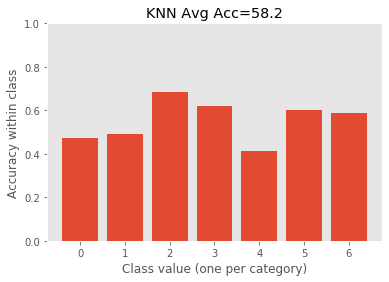

In [0]:
totalacc = 0
totalprec = 0
totalrec= 0
totalf1  = 0
list = []
perclasslist = []
for fold, (train_index, test_index) in enumerate(cv.split(X,Y2)):
     X_train = X[train_index]    
     y_train = Y2[train_index]  # Based on your code, you might need a ravel call here, but I would look into how you're generating your y
     X_test = X[test_index]
     y_test = Y2[test_index]  # See comment on ravel and  y_train
     sm = SMOTE(random_state=101)
     X_train_oversampled, y_train_oversampled = sm.fit_sample(X_train, y_train)
     classifierEstimaterKNN1.fit(X_train, y_train) 
     y_pred = classifierEstimaterKNN1.predict(X_test)
     acc = mt.accuracy_score(y_test,y_pred)
     prec = precision_score(y_test, y_pred, average='weighted')
     rec = recall_score(y_test, y_pred, average='weighted')
     f1 = f1_score(y_test, y_pred, average='weighted')
     perclassaccuracy = per_class_accuracy(y_test,y_pred)
     perclasslist.append(perclassaccuracy.tolist())
     totalacc += acc
     totalprec += prec
     totalrec += rec
     totalf1 += f1
     conf = mt.confusion_matrix(y_test,y_pred)
#     print("Sum: ", totalacc, "Current: ", acc,"Per Class",perclassaccuracy,"\n")


avgaccuracy = 100*totalacc / cv.n_splits
avgprec = 100*totalprec / cv.n_splits
avgrec = 100*totalrec / cv.n_splits
avgf1 = 100*totalf1 / cv.n_splits
 
list = [("Model 1", "KNN", avgaccuracy, avgprec, avgrec, avgf1)]

perclassdf = []
perclassdf = pd.DataFrame(perclasslist)
#perclassdf = perclassdf.transpose()
#perclassdf

perclassavg = perclassdf.mean(axis = 0) 
#perclassavg

plt.bar(range(len(perclassavg)), perclassavg)
plt.xlabel('Class value (one per category)')
plt.ylabel('Accuracy within class')
#plt.title(title+", Total Acc=%.1f"%(totalaccuracy))
plt.title("KNN Avg Acc=%.1f"%(avgaccuracy))
plt.grid()
plt.ylim([0,1])
plt.show()

Looking at the graph above, we can detirmine that class 2, 3 and 5 were the most accurate classes we were predicting. Looking up at the reference key above, these would represent the Gin, Whiskey and Liquer classes respectively. 

In [0]:
ylist = Y['id_label'].values.astype('int64')
ylist
ylist.shape
from sklearn.preprocessing import label_binarize
ybinary = label_binarize(ylist, classes=[1, 2, 3, 4, 5, 6, 7])
n_classes = ybinary.shape[1]

X_train3, X_test3, y_train3, y_test3 = train_test_split(X,ybinary, test_size=0.2)

In [0]:
%%time
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import cross_val_predict
# Learn to predict each class against the other
classifier = OneVsRestClassifier(KNeighborsClassifier(algorithm='auto', leaf_size=10, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='distance'))
knnbinarymodel = classifier.fit(X_train3, y_train3)
knnbinaryscore = knnbinarymodel.predict(X_test3)
y_score = cross_val_predict(classifier, X, ybinary, cv=10 ,method='predict_proba')

CPU times: user 15.9 s, sys: 16.2 ms, total: 15.9 s
Wall time: 15.9 s


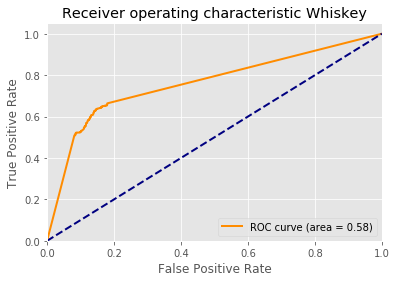

In [0]:
#X1_train, X1_test, y1_train, y1_test
#y_score = classifier.fit(X_train3, y_train3).decision_function(X_test3)
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(ybinary[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(ybinary.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
#Plot of a ROC curve for a specific class

plt.figure()
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[3])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic Whiskey')
plt.legend(loc="lower right")
plt.show()

Now that we plotted our KNN classifier, we can see that the model leans more into true positives than false positives. This shows that are test tends to be more accurate than not. 

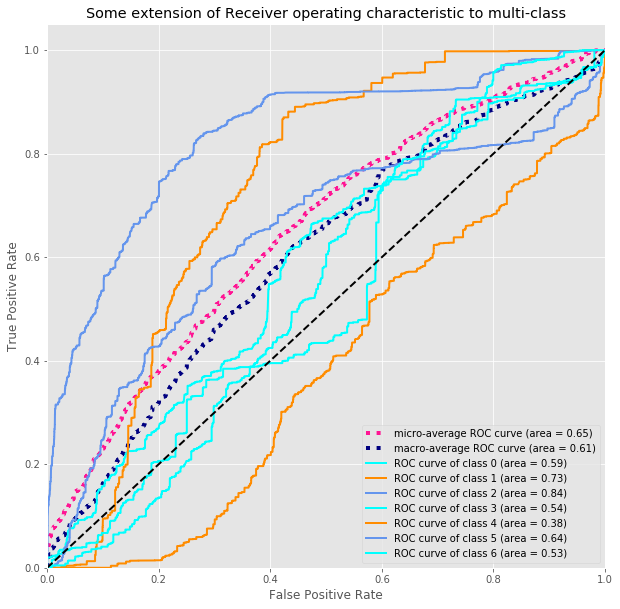

<Figure size 1080x1080 with 0 Axes>

In [0]:
roc_list = []
from scipy import interp
from itertools import cycle
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
roc_list = [("Model 1", "KNN", roc_auc["macro"], fpr["macro"],tpr["macro"])]
# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.rcParams["figure.figsize"] = (10,10)
plt.figure(figsize=(15, 15)) 
plt.show()

Here is a plot of all of our classes in the model. We can see here that the class 5, was the most accurate classifier. That said, note that each curve follows the same guide as the overall model, of being more accurate than not. 

#### Model 2: Random Forest Classification

Details regarding this model are noted in the code below, but to quickly summarize, this model has an average accuracy score of 0.67 and a Precision, Recall, & F1 Score of 0.93, 0.93, & 0.93 respectively.  After cross evaluation there was more factors to be detirmined from the output of our code below. 

In [0]:
param_grid = [
    {
         'n_estimators': [200, 500], 
         'max_depth': [20,30,35],
         'random_state':[101]
     }
]

clf_RF = RandomForestClassifier()
grid_search_RF = GridSearchCV(clf_RF, param_grid=param_grid, cv=cv,n_jobs=-1, verbose=1, scoring='accuracy' )

RandomForest_model1 = grid_search_RF.fit(X1_train_res, y1_train_res)

y_RF_score1 = grid_search_RF.predict(X1_test)


Fitting 10 folds for each of 6 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 15.7min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 21.6min finished


In model 2, we ran a Random Forest Classification procedure to classify liquor types. You can learn more in the documentation below. 

https://stackabuse.com/random-forest-algorithm-with-python-and-scikit-learn/

Like the KNN model before, we decided to run a grid search procedure as well to help us find the optimal hyperparameters to tune to. 

In [0]:
classifierEstimaterRF1 = RandomForest_model1.best_estimator_
classifierEstimaterRF1

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=101,
                       verbose=0, warm_start=False)

After running our Random Forest procedure, we can see the grid search selected, a max depth of 20, a number of estimators split of 500 and no warm start with our model. 

In [0]:

print("Precision Score is: {}" .format(precision_score(y1_test, y_RF_score1, average='weighted')))
print("Recall Score is: {}" .format(recall_score(y1_test, y_RF_score1, average='weighted')))
print("F1 Score is: {}" .format(f1_score(y1_test, y_RF_score1, average='weighted')))


Precision Score is: 0.9299054308005282
Recall Score is: 0.9280980367637864
F1 Score is: 0.92862062463523


Like with the KNN we saw previously, we can see that our precision, recall and F1 scores are very high, which suggest we have a strong model.

In [0]:
%%time
EvaluateClassifierEstimator3(classifierEstimaterRF1, X, Y2, cv)


====Iteration 0  ====
accuracy 0.6731682920730182
confusion matrix
 [[ 140    1   12    3   29   35   19]
 [   3  120    1    0    4   44    0]
 [  35   56  682    1   15  114    1]
 [  28    1   71   87   34    8   56]
 [  56   38   24    0  271  123   24]
 [  33    5    8    6   10 1227   22]
 [  50   28  192   11   64   42  165]]
====Iteration 1  ====
accuracy 0.8312078019504876
confusion matrix
 [[ 124    5   73    1    8   24    4]
 [   1  136   18    1    8    8    0]
 [  19   22  843    1    5    5    9]
 [   0    0    0  280    0    5    0]
 [   0    0    2   11  378   94   51]
 [   2    0    0    0   18 1279   12]
 [  37    8   42   28  132   21  284]]
====Iteration 2  ====
accuracy 0.8107026756689172
confusion matrix
 [[ 129    1   60   13   11   21    4]
 [   2   77   26    0   54   10    2]
 [  48    2  819    0    1    3   32]
 [   0    0    0  282    0    3    0]
 [  35   18    5    1  362  102   13]
 [  22    2    0    0   27 1252    8]
 [  90    0    7   97   10   27  3

Running through each iteration of our kfold, we can see that our accuracy score ranges from 0.46 to 0.83. 

In [0]:
from sklearn.model_selection import cross_val_score

RF_accuracy = cross_val_score(classifierEstimaterRF1, X, y=Y2, cv=cv)
RF_acc=RF_accuracy.mean()
print('Average RF accuracy score is : {}' .format(RF_acc))

Average RF accuracy score is : 0.6716029244930041


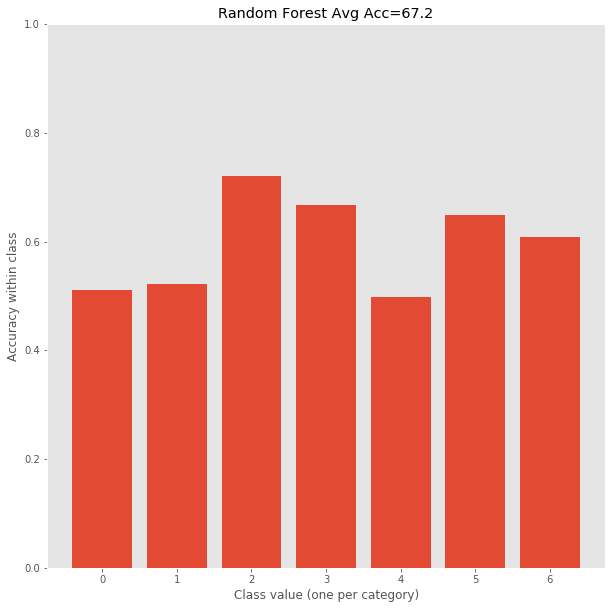

In [0]:
totalacc = 0
totalprec = 0
totalrec= 0
totalf1  = 0

for fold, (train_index, test_index) in enumerate(cv.split(X,Y2)):
     X_train = X[train_index]    
     y_train = Y2[train_index]  # Based on your code, you might need a ravel call here, but I would look into how you're generating your y
     X_test = X[test_index]
     y_test = Y2[test_index]  # See comment on ravel and  y_train
     sm = SMOTE(random_state=101)
     X_train_oversampled, y_train_oversampled = sm.fit_sample(X_train, y_train)
     classifierEstimaterRF1.fit(X_train, y_train) 
     y_pred = classifierEstimaterRF1.predict(X_test)
     acc = mt.accuracy_score(y_test,y_pred)
     prec = precision_score(y_test, y_pred, average='weighted')
     rec = recall_score(y_test, y_pred, average='weighted')
     f1 = f1_score(y_test, y_pred, average='weighted')
     perclassaccuracy = per_class_accuracy(y_test,y_pred)
     perclasslist.append(perclassaccuracy.tolist())
     totalacc += acc
     totalprec += prec
     totalrec += rec
     totalf1 += f1
     conf = mt.confusion_matrix(y_test,y_pred)
#     print("Sum: ", totalacc, "Current: ", acc,"Per Class",perclassaccuracy,"\n")


avgaccuracy = 100*totalacc / cv.n_splits
avgprec = 100*totalprec / cv.n_splits
avgrec = 100*totalrec / cv.n_splits
avgf1 = 100*totalf1 / cv.n_splits
 

list.append(("Model 2", "Random Forest", avgaccuracy, avgprec, avgrec, avgf1))

perclassdf = []
perclassdf = pd.DataFrame(perclasslist)
#perclassdf = perclassdf.transpose()
#perclassdf

perclassavg = perclassdf.mean(axis = 0) 
#perclassavg

plt.bar(range(len(perclassavg)), perclassavg)
plt.xlabel('Class value (one per category)')
plt.ylabel('Accuracy within class')
#plt.title(title+", Total Acc=%.1f"%(totalaccuracy))
plt.title("Random Forest Avg Acc=%.1f"%(avgaccuracy))
plt.grid()
plt.ylim([0,1])
plt.show()

Like our previous models, we can see class 2, 3 and 5 were the most accurately predicted classes in our model. 

In [0]:
ylist = Y['id_label'].values.astype('int64')
ylist
ylist.shape

(39983,)

In [0]:
list

[('Model 1',
  'KNN',
  58.23395818939728,
  58.34350559044941,
  58.23395818939728,
  56.50715998546683),
 ('Model 2',
  'Random Forest',
  67.1602924493004,
  68.6592368482461,
  67.1602924493004,
  66.05111493740495)]

In [0]:
from sklearn.preprocessing import label_binarize
ybinary = label_binarize(ylist, classes=[1, 2, 3, 4, 5, 6, 7])
n_classes = ybinary.shape[1]

X_train4, X_test4, y_train4, y_test4 = train_test_split(X,ybinary, test_size=0.2) # 70% training and 30% test

In [0]:
%%time
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import cross_val_predict
# Learn to predict each class against the other
rfclassifiercv = OneVsRestClassifier(RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=101,
                       verbose=0, warm_start=False))
rfbinarymodel = rfclassifiercv.fit(X_train4, y_train4)
rfbinaryscore = rfclassifiercv.predict(X_test4)
y_score = cross_val_predict(rfclassifiercv, X, ybinary, cv=10 ,method='predict_proba')

CPU times: user 20min 49s, sys: 6.3 s, total: 20min 55s
Wall time: 20min 58s


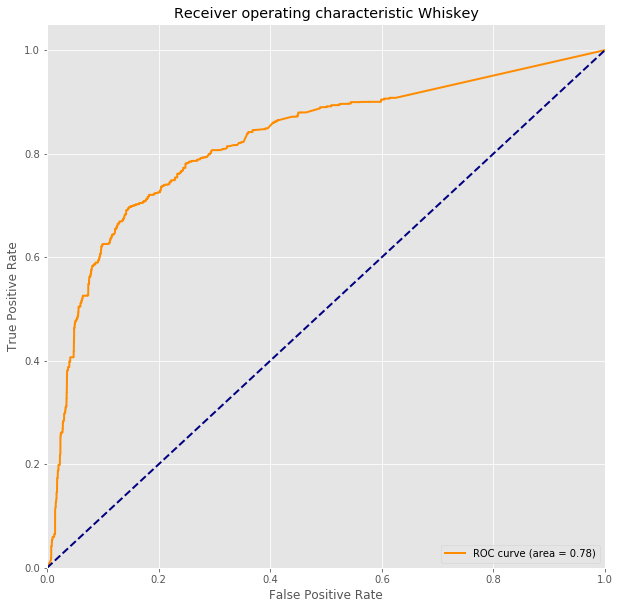

In [0]:
#X1_train, X1_test, y1_train, y1_test
#y_score = classifier.fit(X_train3, y_train3).decision_function(X_test3)
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(ybinary[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(ybinary.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
#Plot of a ROC curve for a specific class

plt.figure()
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[3])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic Whiskey')
plt.legend(loc="lower right")
plt.show()

Looking at the average value ROC curve, we can see this model was the strongest performer as indicated by the area under the curve. 

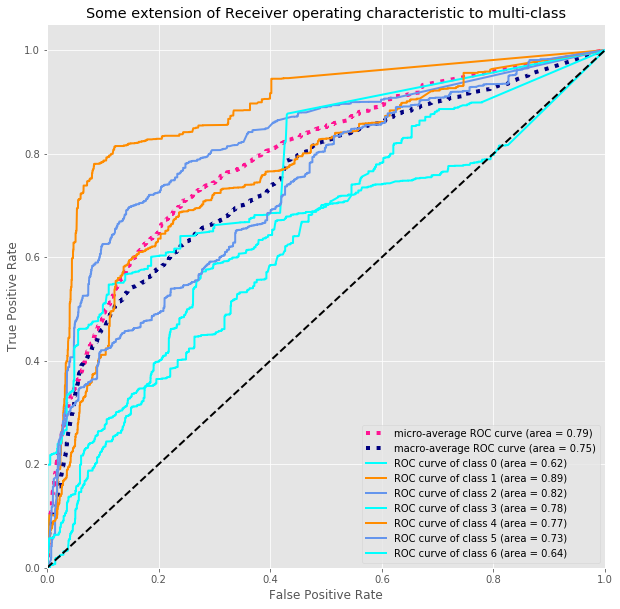

In [0]:
from scipy import interp
from itertools import cycle
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
roc_list.append(("Model 2", "RF", roc_auc["macro"],fpr["macro"],tpr["macro"]))
# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.rcParams["figure.figsize"] = (10,10)
plt.show()

With an ROC curve of the classes, we can see the random forest was pretty accurate in predicting each of the classes, with a positive outcome on each curve. 

#### Final Model chosen

### Task 1 - Modeling and Evaluation 4  
Analyze the results using your chosen method of evaluation. Use visualizations of the results to bolster the analysis. Explain any visuals and analyze why they are interesting to someone that might use this model.

Analyze the results using your chosen method of evaluation. Use visualizations of the results to bolster the analysis. Explain any visuals and analyze why they are interesting to someone that might use this model.

AUC for both KNN and Random Forest classifier is the same.The best model accuracy was Random Forest Classification at 67%, the highest of 3 models evaluated.

We plotted the 3 ROC curves on a graph (see below). The shape of each ROC curve is not the same for all suggesting some models are better at producting classes of alcohol. Random Forest has the largest area under the curve suggesting it is the best of the 3.

The computation time taken by each model was comparable between each other. This leads to the conclusion that the Random Forest.




In [0]:
print ('accuracy for KNN classifier is :',KNN_acc)
print ('accuracy for Random Forest classifier is :',RF_acc)
print ('accuracy for Logistic Regression classifier is :',LR_acc)

accuracy for KNN classifier is : 0.5823395818939727
accuracy for Random Forest classifier is : 0.6716029244930041
accuracy for Logistic Regression classifier is : 0.2722635573850941


In [0]:
list
dfobj = pd.DataFrame(list, columns = ['Model Number', 'Model','Accuracy' , 'Precision', 'Recall', 'F1'], index=['0', '1', '2'])
dfobj

,Model Number,Model,Accuracy,Precision,Recall,F1
0,Model 1,KNN,58.233958,58.343506,58.233958,56.507160
1,Model 2,Random Forest,67.160292,68.659237,67.160292,66.051115
2,Model 3,Logistic Regression,27.226356,37.160409,27.226356,27.604865


In [0]:
dfroc = pd.DataFrame(roc_list, columns = ['Model Number', 'Model', 'ROC', "fpr", "tpr"], index=['0', '1', '2'])
dfroc

,Model Number,Model,ROC,fpr,tpr
0,Model 1,KNN,0.587234,"[0.0, 0.022273094532722866, 0.0223269593320764...","[0.0, 0.09158371380516994, 0.091736174092466, ..."
1,Model 2,RF,0.751273,"[0.0, 5.386479935362241e-05, 8.07971990304336e...","[5.987306909352174e-05, 0.02477672466686168, 0..."
2,Model 2,LR,0.606728,"[0.0, 2.6132176548984765e-05, 3.23227099360010...","[0.0013478748164938664, 0.0013478748164938664,..."


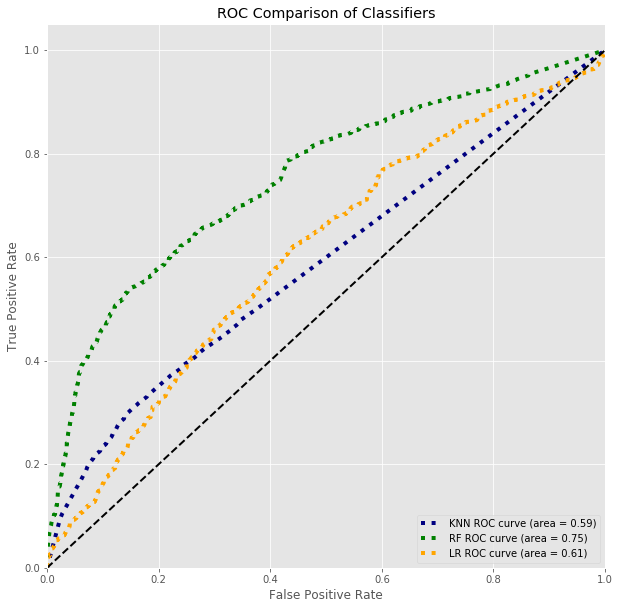

In [0]:
plt.plot(dfroc.iloc[0, 3], dfroc.iloc[0, 4],
         label='KNN ROC curve (area = {0:0.2f})'
               ''.format(dfroc.iloc[0, 2]),
         color='navy', linestyle=':', linewidth=4)

plt.plot(dfroc.iloc[1, 3], dfroc.iloc[1, 4],
         label='RF ROC curve (area = {0:0.2f})'
               ''.format(dfroc.iloc[1, 2]),
         color='green', linestyle=':', linewidth=4)

plt.plot(dfroc.iloc[2, 3], dfroc.iloc[2, 4],
         label='LR ROC curve (area = {0:0.2f})'
               ''.format(dfroc.iloc[2, 2]),
         color='orange', linestyle=':', linewidth=4)

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Comparison of Classifiers')
plt.legend(loc="lower right")
plt.rcParams["figure.figsize"] = (10,10)
plt.show()

### Task 1 - Modeling and Evaluation 5  
Discuss the advantages of each model for each classification task, if any. If there are not advantages, explain why. Is any model better than another? Is the difference significant with 95% confidence? Use proper statistical comparison methods. You must use statistical comparison techniques—be sure they are appropriate for your chosen method of validation as discussed in unit 7 of the course.




Advantages and overall assumptions for each of the three models we ran for task 1 are outlined below.  

For the KNN model, the main advantage was speed.  For example, the KNN model was able to finish running in under 3 minutes vs Random Forest and Logistic Regression which was greater than 20 minutes each.   Note, eventhough the model was quicker to run it did not provide us the best model statistics. 

For the Random Forest, the main advantage was predictability.  This could be due to the fact that Random Forest does well with highly dimensional data.  Furthermore, this is the best performing model with an accuaracy score at 0.67, and a Precision, Recall, & F1 Score of 0.93, 0.93, & 0.93 respectively. 

For the Logistic Regression model, the main advantage was that we were able to run the most number of different parameters as compared to other models.  Due to running 16 different parameter tests, the overall grid search + model was the slowest at 24.5 minutes.  In terms of predictability, this was the worst performing model. 



#### Statistical Comparisons of Classifiers

Null Hypothesis = there is no significant difference in classifier scores among our models. 
Alt Hypothesis = There is a significant difference in our models. 

T value is 2.26

Confidence interval is 95%

In [0]:
from sklearn.model_selection import cross_val_score
acc_KNN_t1 = cross_val_score(classifierEstimaterKNN1, X, y=Y, cv=cv)
acc_RF_t1 = cross_val_score(classifierEstimaterRF1, X, y=Y, cv=cv)
acc_LR_t1 = cross_val_score(classifierEstimaterLR, X, y=Y, cv=cv)

In [0]:
print ('accuracy for KNN classifier is :',acc_KNN_t1)
print ('accuracy for Random Forest classifier is :',acc_RF_t1)
print ('accuracy for Logistic Regression Classifier is :',acc_LR_t1)

accuracy for KNN classifier is : [0.60265066 0.79969992 0.66116529 0.43446723 0.67333667 0.59254627
 0.55827914 0.64057029 0.48149075 0.37918959]
accuracy for Random Forest classifier is : [0.67316829 0.8312078  0.81070268 0.47798899 0.74762381 0.71135568
 0.62931466 0.76213107 0.60455228 0.46798399]
accuracy for Logistic Regression Classifier is : [0.32733183 0.36634159 0.20930233 0.17083542 0.4132066  0.37343672
 0.21485743 0.20735368 0.1935968  0.24637319]


In [0]:
#Is t-value right here???
t = 2.26 / np.sqrt(10)

e_KNN_RF_t1 = (1-acc_KNN_t1)-(1-acc_RF_t1)
e_KNN_LR_t1 = (1-acc_KNN_t1)-(1-acc_LR_t1)
e_RF_LR_t1 = (1-acc_RF_t1)-(1-acc_LR_t1)


stdtot_K_R_t1 = np.std(e_KNN_RF_t1)
stdtot_K_L_t1 = np.std(e_KNN_LR_t1)
stdtot_R_L_t1 = np.std(e_RF_LR_t1)


dbarKR_t1 = np.mean(e_KNN_RF_t1)
dbarKL_t1 = np.mean(e_KNN_LR_t1)
dbarRL_t1 = np.mean(e_RF_LR_t1)


print ('Range of KNN_RF confidence interval:[%0.6f,%0.6f]' % (dbarKR_t1-t*stdtot_K_R_t1,dbarKR_t1+t*stdtot_K_R_t1))
print ('Range of KNN_LR confidence interval:[%0.6f,%0.6f]' % (dbarKL_t1-t*stdtot_K_L_t1,dbarKL_t1+t*stdtot_K_L_t1))
print ('Range of RF_LR confidence interval:[%0.6f,%0.6f]' % (dbarRL_t1-t*stdtot_R_L_t1,dbarRL_t1+t*stdtot_R_L_t1))

Range of KNN_RF confidence interval:[0.063468,0.115059]
Range of KNN_LR confidence interval:[-0.380690,-0.239462]
Range of RF_LR confidence interval:[-0.477818,-0.320861]


According to the intervals above, all of the relationships are statistically significant at the 95% level. So we would reject the null hypothesis. This is indicated by the fact that none of the interval range passes through 0. This means that they are all statistically significant. The code above shows our confidence intervals at 95%.

### Task 1 - Modeling and Evaluation 6  
Which attributes from your analysis are most important? Use proper methods discussed in class to evaluate the importance of different attributes. Discuss the results and hypothesize about why certain attributes are more important than others for a given classification task.


As you will see in the charts below, the cost_per_liter_trans is the most important feature, followed by state_bottle_cost_trans, pack_trans, and bottle_volume_ml_trans.  

This correlates well with our assumptions since each liquor type may have a different cost per liter, as well as the pack and bottle volume sold.   With that said, the model is using these features to help classify the different liquor types within our dataset. 

In [0]:
importances = classifierEstimaterRF1.feature_importances_
importances

array([0.07569612, 0.29275988, 0.25261299, 0.0144542 , 0.03469669,
       0.05725532, 0.06067744, 0.06713809, 0.0720781 , 0.07263117])

In [0]:
classes = classifierEstimaterRF1.classes_
classes

array(['1', '2', '3', '4', '5', '6', '7'], dtype=object)

In [0]:
classifierEstimaterRF1.base_estimator_

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [0]:
from sklearn.inspection import permutation_importance
result = permutation_importance(classifierEstimaterRF1, X1_test, y1_test, n_repeats=10,
                                random_state=42, n_jobs=-1)

result
#X1_train, X1_test, y1_train, y1_test

{'importances': array([[-0.0018757 , -0.0018757 , -0.00250094, -0.00175066, -0.00225084,
         -0.00262598, -0.00225084, -0.00100038, -0.00112542, -0.00125047],
        [ 0.30811554,  0.30386395,  0.30273853,  0.30736526,  0.30023759,
          0.30136301,  0.29711142,  0.30461423,  0.30874078,  0.31361761],
        [ 0.15955983,  0.16468676,  0.16256096,  0.16181068,  0.15955983,
          0.16156059,  0.16231087,  0.16656246,  0.16606227,  0.16043516],
        [-0.00225084, -0.00300113, -0.00150056, -0.00237589, -0.00250094,
         -0.00237589, -0.00300113, -0.0021258 , -0.00325122, -0.00262598],
        [-0.00262598, -0.00162561, -0.00087533, -0.00312617, -0.00050019,
         -0.00375141, -0.00275103, -0.00200075, -0.00137552, -0.00362636],
        [ 0.09753658,  0.09753658,  0.09391022,  0.09503564,  0.09803676,
          0.09553583,  0.09966237,  0.10041265,  0.09391022,  0.09903714],
        [ 0.02475928,  0.02225835,  0.0280105 ,  0.02563461,  0.02813555,
          0.02488

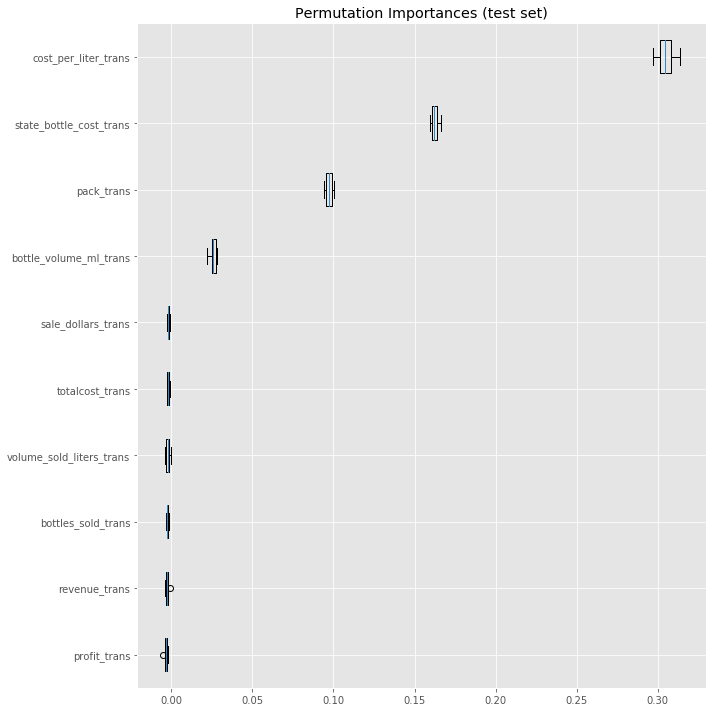

In [0]:
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=X2.columns[sorted_idx])
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()

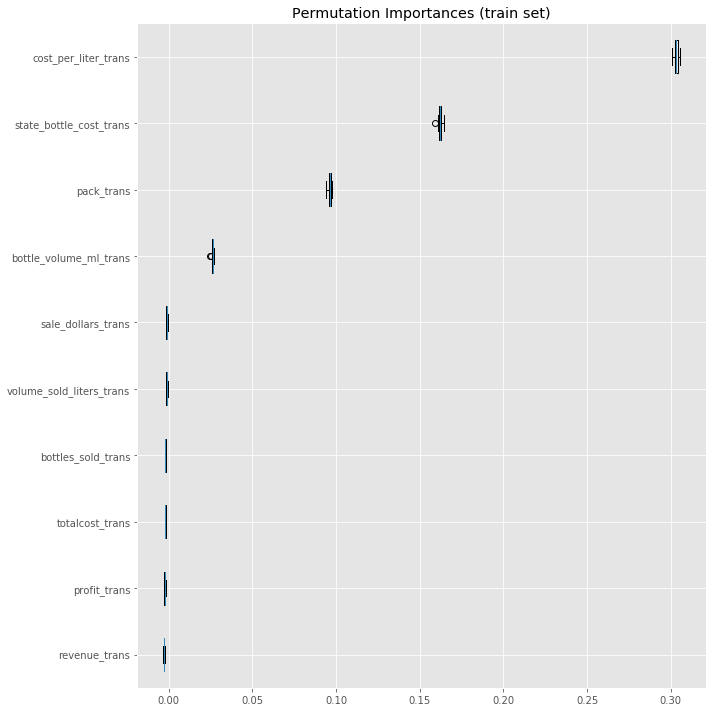

In [0]:
result = permutation_importance(classifierEstimaterRF1, X1_train, y1_train, n_repeats=10,
                                random_state=42, n_jobs=-1)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=X2.columns[sorted_idx])
ax.set_title("Permutation Importances (train set)")
fig.tight_layout()
plt.show()